In [84]:
import time
import random
import signal
import math
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import SVG

infty = float('inf')

## Utilities
### Decorators

In [85]:
def handler(sig, frame):
    raise Exception("Function takes too much time")

def timelimit(maxtime=100):
    def inner(func):
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, handler)
            signal.alarm(maxtime)
            try:
                res = func(*args, **kwargs)
            except Exception as exc:
                print(exc)
            else:
                signal.alarm(-1)
                return res
        return wrapper
    return inner

def timecounter(message=None):
    def inner(func):
        def wrapper(*args, **kwargs):
            start = time.time()
            res = func(*args, **kwargs)
            deltatime = (time.time() - start)*1000
            if message:
                try:
                    print(message.format(deltatime))
                except Exception:
                    print(f"Done in {deltatime}ms")
            elif message == False:
                return res, deltatime
            else:
                print(f"Done in {deltatime}ms")
            return res
        return wrapper
    return inner

def add_weights_svg(svg, weights):
    res_svg = svg.rsplit("\n", 3)[0]
    sep = 'pt" height="'
    a, b = res_svg.split(sep, 1)
    width = int(a[-3:])
    height = int(b[:3])
    h = height/len(weights)
    w_svg = "\n" + "\n".join([f"""<text text-anchor="middle" x="{width+20}" y="{-h*(i+.5)}" font-family="Times,serif" font-size="14.00">{x:.2f}</text>"""for i, x in enumerate(weights[::-1])])
    w_svg+="""\n</g>\n</svg>"""

    a = f"{a[:-3]}{width+100}"
    res_svg = a + sep + b + w_svg

    return res_svg

### Cache related functions

In [86]:
cache = dict()

def reset_cache():
    cache.clear()

def store_in_cache(k, node):
    if cache.get(k):
        cache[k].append(node)
    else:
        cache.update({k: [node]})

def find_in_cache(k, value):
    cache_line = cache.get(k)
    if cache_line:
        for node in cache_line:
            if value in node.interval:
                return node
    return None

def cache_total_node_count():
    node_count = 0
    for x in cache.values():
        node_count+=x.__len__()
    return node_count

### Draw graph

In [87]:
def make_graph_from_cache(name=None):
    dot = Digraph()
    for cache_line in cache.values():
        for node in cache_line:
            dot.node(node.id, f"{node.interval:.2f}")
            for e, child in node.child.items():
                dot.edge(node.id, child.id, str(e))

    if name:
        dot.render(filename=f"odd/{name}")
    return dot._repr_image_svg_xml()

## Class implementation

In [88]:
class Node:
    def __init__(self, interval=None, name=None):
        self.child = dict()
        self.parent = dict()
        self.interval = interval
        self.name = name
        self.id = f"n{id(self)}"

    def __str__(self):
        return f"{self.child.__len__()} children | {self.parent.__len__()} parents | {self.interval:.2f}"
    
    def add_child(self, other, label):
        self.child.update({label: other})
        other.parent.update({label: self})

class Interval:
    def __init__(self, low, high, closed_left=True, closed_right=True):
        self.low = low
        self.high = high
        self.left = closed_left
        self.right = closed_right
    
    def __str__(self):
        left = "[" if self.left else "("
        right = "]" if self.right else ")"
        return f"{left}{self.low}; {self.high}{right}"

    def __format__(self, __format_spec):
        left = "[" if self.left else "("
        right = "]" if self.right else ")"
        if __format_spec:
            return f"{left}{self.low:{__format_spec}}; {self.high:{__format_spec}}{right}"
        else:
            return f"{left}{self.low}; {self.high}{right}"

    def __add__(self, value):
        return Interval(self.low + value, self.high + value, self.left, self.right)

    def __sub__(self, value):
        return Interval(self.low - value, self.high - value, self.left, self.right)

    def __contains__(self, value):
        down = value >= self.low if self.left else value > self.low
        up = value <= self.high if self.right else value < self.high
        return down & up
    
    def intersect(self, other):
        if self.low < other.low:
            self.low = other.low
            self.left = other.left
        elif self.low == other.low:
            self.left &= other.left
        
        if self.high > other.high:
            self.high = other.high
            self.right = other.right
        elif self.high == other.high:
            self.right &= other.right

        return self

## Build ODD

In [89]:
@timecounter(message=False)
def timed_build_odd_rec(weights_list, threshold):
    return _build_odd_rec(weights_list, threshold)

@timecounter(message="Built recursively in {:.2f}ms")
def build_odd_rec(weights_list, threshold):
    return _build_odd_rec(weights_list, threshold)

@timelimit(600)
def _build_odd_rec(weights_list, threshold):
    n = len(weights_list)
    one_sink = Node(Interval(threshold, infty, closed_right=False))
    store_in_cache(n, one_sink)
    zero_sink = Node(Interval(-infty, threshold, closed_left=False, closed_right=False))
    store_in_cache(n, zero_sink)
    return build_sub_odd_rec(weights_list, 0, 0)

def build_sub_odd_rec(weights, k, v):
    node = Node(Interval(-infty, infty, closed_left=False, closed_right=False))
    weight = weights[k]
    for e in {0, 1}:
        w = e*weight
        v_child = v + w
        child = find_in_cache(k+1, v_child)
        if child is None:
            child = build_sub_odd_rec(weights, k+1, v_child)
        node.add_child(child, e)
        node.interval.intersect(child.interval-w)
    store_in_cache(k, node)
    return node

## Main

Built recursively in 0.08ms


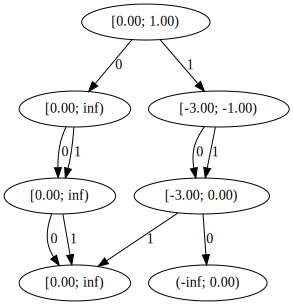

In [100]:
n_weights = 5
weights = [(random.random()-.5)*5 for _ in range(n_weights)] # 27 in 10s / 30 ~ 1min
weights = [-2, 1, 3]
threshold = 0

reset_cache()
odd = build_odd_rec(weights, threshold)
odd_svg = make_graph_from_cache()
odd_svg = add_weights_svg(odd_svg, weights)
SVG(odd_svg)

## Experiences

In [91]:
t = 0
n_it = 5
test_range = list(range(2, 31))

rand_time = {k: 0 for k in test_range}
rand_node = {k: 0 for k in test_range}
asc_time  = {k: 0 for k in test_range}
asc_node  = {k: 0 for k in test_range}
desc_time = {k: 0 for k in test_range}
desc_node = {k: 0 for k in test_range}
for n in test_range:
    for i in range(n_it):
        print(n, i, end="\r")
        reset_cache()
        weights = [(random.random()-.5)*5 for _ in range(n)]
        odd, delta = timed_build_odd_rec(weights, t)
        rand_time[n]+=delta
        rand_node[n]+=cache_total_node_count()
        reset_cache()
        weights = sorted(weights)
        odd, delta = timed_build_odd_rec(weights, t)
        asc_time[n]+=delta
        asc_node[n]+=cache_total_node_count()
        reset_cache()
        weights = weights[::-1]
        odd, delta = timed_build_odd_rec(weights, t)
        desc_time[n]+=delta
        desc_node[n]+=cache_total_node_count()

rand_time = {k: v/n_it for k, v in rand_time.items()}
rand_node = {k: v/n_it for k, v in rand_node.items()}
asc_time  = {k: v/n_it for k, v in asc_time.items()}
asc_node  = {k: v/n_it for k, v in asc_node.items()}
desc_time = {k: v/n_it for k, v in desc_time.items()}
desc_node = {k: v/n_it for k, v in desc_node.items()}

/tmp/ipykernel_5483/3096521058.py:30: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


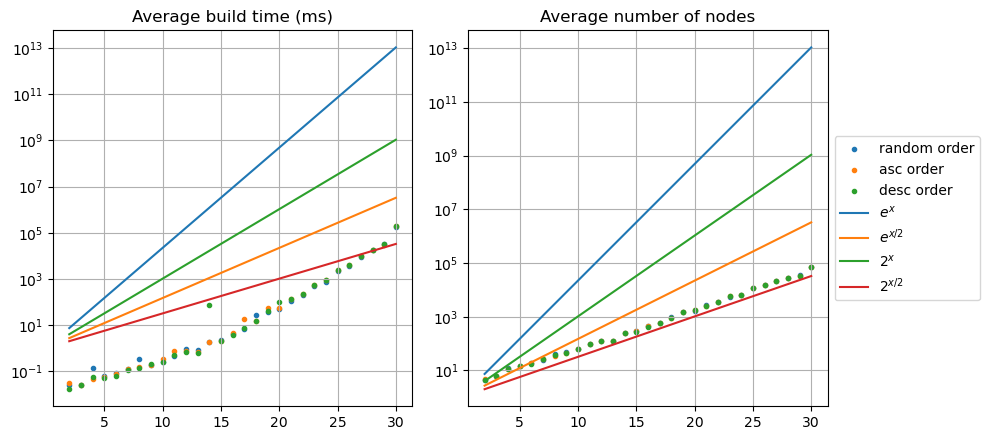

In [98]:
exp_curve = [math.exp(x) for x in test_range]
exp_half_curve = [math.exp(x/2) for x in test_range]
pow_curve = [2**x for x in test_range]
pow_half_curve = [2**(x/2) for x in test_range]

fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(10,4.5))
ax0, ax1 = axs
ax0.scatter(test_range, list(rand_time.values()), marker='.')
ax0.scatter(test_range, list(asc_time.values()), marker='.')
ax0.scatter(test_range, list(desc_time.values()), marker='.')
ax0.plot(test_range, exp_curve)
ax0.plot(test_range, exp_half_curve)
ax0.plot(test_range, pow_curve)
ax0.plot(test_range, pow_half_curve)
ax0.set_yscale('log')
ax0.grid()
ax0.set_title("Average build time (ms)")

ax1.scatter(test_range, list(rand_node.values()), marker='.', label="random order")
ax1.scatter(test_range, list(asc_node.values()), marker='.', label="asc order")
ax1.scatter(test_range, list(desc_node.values()), marker='.', label="desc order")
ax1.plot(test_range, exp_curve, label="$e^x$")
ax1.plot(test_range, exp_half_curve, label="$e^{x/2}$")
ax1.plot(test_range, pow_curve, label="$2^x$")
ax1.plot(test_range, pow_half_curve, label="$2^{x/2}$")
ax1.set_yscale('log')
ax1.grid()
ax1.set_title("Average number of nodes")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [43]:
test_threshold = [-1000, -500, -100, -50, -10, -5, 0, 5, 10, 50, 100, 500, 1000]
n_it = 1000
n_weights = 12
res_time = {k: 0 for k in test_threshold}
res_node = {k: 0 for k in test_threshold}
for i in range(n_it):
    weights = [(random.random()-.5)*100 for _ in range(n_weights)]
    print(f"{i: 2d}", end="\r")
    for t in test_threshold:
        reset_cache()
        odd, delta = timed_build_odd_rec(weights, t)
        res_time[t]+=delta
        res_node[t]+=cache_total_node_count()

res_time = {k: v/n_it for k, v in res_time.items()}
res_node = {k: v/n_it for k, v in res_node.items()}

/tmp/ipykernel_5483/648651926.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


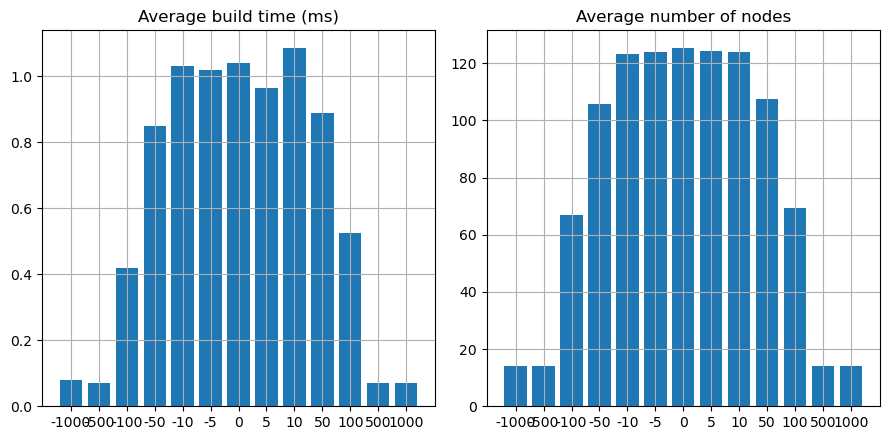

In [44]:
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(9,4.5))
ax0, ax1 = axs
ax0.bar([str(k) for k in res_time.keys()], list(res_time.values()))
ax0.grid()
ax0.set_title("Average build time (ms)")
ax1.bar([str(k) for k in res_node.keys()], list(res_node.values()))
ax1.grid()
ax1.set_title("Average number of nodes")
fig.tight_layout()